In [1]:
import sys, os
sys.path.append(os.path.abspath("/Users/DavidHolzwarth/Uni/EPFL/bachelors-thesis"))

import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress


import LE as le
import LP as lp
import iterative as iterative
import graph_viz as viz
import logger_creator

from graph_gen import create_delegation_graph
import graph_tools
import networkx as nx

/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/dash_bootstrap_components/_table.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [3]:
range_x = range(0, 1001, 100)

time_data_le = []
time_data_lp = []
time_data_iterative = []

logger, handler = logger_creator.create_logger("benchmarking")

for num_loops in range(1):
    times_le = []
    times_lp = []
    times_iterative = []

    for num_nodes in range_x:
        print(num_nodes)

        big_loop = nx.DiGraph()
        # We're creating a graph with one node too many technically
        for i in range(num_nodes):
            if i == 0:
                # Add split edge: 0.9 to the next node
                big_loop.add_edge(i, (i + 1) % num_nodes, weight=0.9)
                # Add the external node and edge with weight 0.1
                big_loop.add_edge(i, num_nodes, weight=0.1)  # external node has index `n`
            else:
                big_loop.add_edge(i, (i + 1) % num_nodes, weight=1.0)
                                
        big_loop = graph_tools.nx_graph_nodes_to_str(big_loop)
        delegations_orig = graph_tools.nx_graph_to_dict(big_loop)
        delegations = graph_tools.invert_graph(delegations_orig)
        nodes = list(big_loop)

        # Verify the solutions are equal
        powers_le, sinks_le = le.resolve_delegations(delegations, nodes)
        powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
        powers_iter = iterative.iterate_delegations(delegations, nodes)

        if powers_le.keys() != powers_lp.keys() or any(abs(powers_le[k] - powers_lp[k]) > 10**-6 for k in powers_le):
            logger.error("Powers do not match")
            logger.error(f"LE: {powers_le}")
            logger.error(f"LP: {powers_lp}")
            print("Mismatching powers in LE and LP. Check the log file for details.")
            break

        for node in sinks_le:
            if (powers_lp[node] - powers_iter[node] < 0.01):
                continue
            else: 
                logger.error("Powers do not match")
                logger.error(f"LP: {powers_lp}")
                logger.error(f"Iterative: {powers_iter}")
                print("Mismatching powers in LP and Iterative. Check the log file for details.")
                break

        n = 5
        if 0 <= num_nodes < 100:
            n = 100
        elif 100 <= num_nodes < 500:
            n = 20

        # LE
        le_model = le.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            le.solve(*le_model)
        end_time = time.time()
        
        times_le.append((end_time - start_time) / n)

        # LP
        lp_model = lp.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            lp.solve(*lp_model)
        end_time = time.time()

        times_lp.append((end_time - start_time) / n)
    
        # Iterative
        start_time = time.time()
        for _ in range(n):
            p = iterative.iterate_delegations(delegations, nodes)
        end_time = time.time()

        times_iterative.append((end_time - start_time) / n)


    time_data_le.append(times_le)
    time_data_lp.append(times_lp)
    time_data_iterative.append(times_iterative)

logger.removeHandler(handler)
handler.close()

x = list(range_x)

0
100
200
300
400


KeyboardInterrupt: 

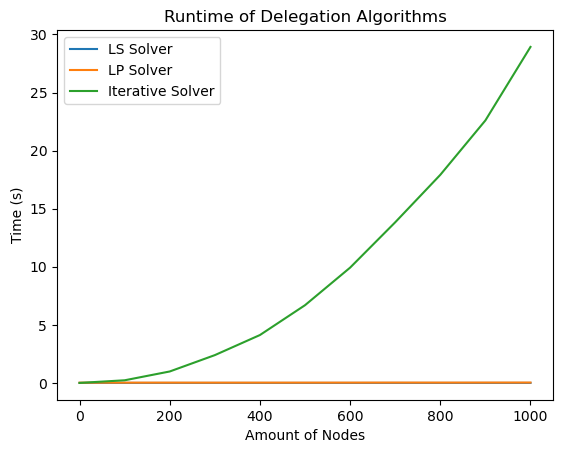

In [14]:
plt.clf()

for i in range(len(time_data_lp)):
    plt.plot(x, time_data_le[i], label=f"LS Solver")
    plt.plot(x, time_data_lp[i], label=f"LP Solver") 
    plt.plot(x, time_data_iterative[i], label=f"Iterative Solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtime of Delegation Algorithms")
plt.show()

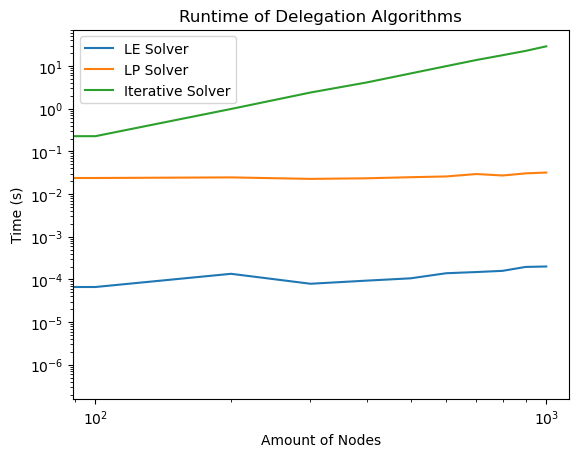

In [20]:
for i in range(len(time_data_lp)):
    plt.plot(x, time_data_le[i], label=f"LE Solver")
    plt.plot(x, time_data_lp[i], label=f"LP Solver") 
    plt.plot(x, time_data_iterative[i], label=f"Iterative Solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtime of Delegation Algorithms")
plt.loglog()
plt.show()

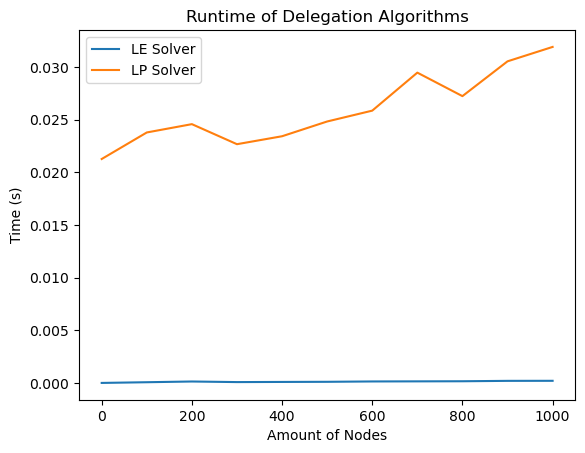

In [21]:
plt.figure()

for i in range(len(time_data_lp)):
    plt.plot(x, time_data_le[i], label=f"LE Solver")
    plt.plot(x, time_data_lp[i], label=f"LP Solver") 
    #plt.plot(x, time_data_iterative[i], label=f"Iterative Solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtime of Delegation Algorithms")
plt.show()

In [16]:
print(x)
print("time_data_iterative")
print(time_data_iterative)
print("time_data_le")
print(time_data_le)
print("time_data_lp")
print(time_data_lp)

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
time_data_iterative
[[6.752967834472656e-05, 0.22694790363311768, 0.9858863115310669, 2.3935359954833983, 4.1228631973266605, 6.691752791404724, 9.925139999389648, 13.828160309791565, 17.91322019100189, 22.596851706504822, 28.923641085624695]]
time_data_le
[[3.8862228393554685e-07, 6.647109985351563e-05, 0.00013549327850341796, 7.920265197753906e-05, 9.379386901855468e-05, 0.00010612010955810547, 0.00013971328735351562, 0.00014901161193847656, 0.0001589059829711914, 0.00019631385803222656, 0.00020101070404052735]]
time_data_lp
[[0.021266231536865233, 0.023786592483520507, 0.024576401710510253, 0.02267310619354248, 0.023427891731262206, 0.02482919692993164, 0.025859618186950685, 0.02946920394897461, 0.027237892150878906, 0.030542421340942382, 0.03191099166870117]]


In [ ]:
# Log log runtime

log_x = np.log(x[1:])
log_y = np.log(time_data_iterative[0][1:])
slope, intercept, r_value, _, _ = linregress(log_x, log_y)
print('R2', r_value**2, 'slope', slope, 'intercept', intercept)

R2 0.9997427621995872 slope 2.1174227059937576 intercept -10.658958135578056


# Visualize Example Loops

In [11]:
big_loop = nx.DiGraph()
num_nodes = 9
# We're creating a graph with one node too many technically
for i in range(num_nodes):
    if i == 0:
        # Add split edge: 0.9 to the next node
        big_loop.add_edge(i, (i + 1) % num_nodes, weight=0.9)
        # Add the external node and edge with weight 0.1
        big_loop.add_edge(i, num_nodes, weight=0.1)  # external node has index `n`
    else:
        big_loop.add_edge(i, (i + 1) % num_nodes, weight=1.0)
            
big_loop = graph_tools.nx_graph_nodes_to_str(big_loop)
delegations_orig = graph_tools.nx_graph_to_dict(big_loop)
delegations = graph_tools.invert_graph(delegations_orig)
nodes = list(big_loop)

viz.visualize_delegation_graph(delegations_orig)

Parsing the data...Done
Parsing the data...Done
Parsing the data...Done


Address already in use
Port 8050 is in use by another program. Either identify and stop that program, or start the server with a different port.
Address already in use
Port 8051 is in use by another program. Either identify and stop that program, or start the server with a different port.


Graph visualization failed because no ports were found or there was another error.


No trigger
